### Импорт библиотек
Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### Загрузим датасеты.

#### Location
**01_Location_July.csv** и **01_CLocation_July.csv** - Сгенерированный датасет о численности населения на территории Москвы и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные об изменении численности населения на территории

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***
- Количество человек, проживающих на территории района/сектора
- Количество человек, работающих на территории района/сектора
- Количество человек, которые находились на территории района/сектора по будням в дневное время чаще, чем в любых других районах/секторах, в рассматриваемый месяц
- Количество человек, проживающих на территории района/сектора и имеющих разъездную работу

In [2]:
df_cloc = pd.read_csv('./datasets/01_CLocation_July.csv')
df_cloc.head(3)

,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,32909,4,0,0,0
1,32910,25,8,26,0
2,33261,2,0,2,0


In [3]:
df_cloc.describe()

,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
count,10240.000000,10240.000000,10240.000000,10240.000000,10240.000000
mean,83354.220801,849.844043,437.173340,746.294727,46.906055
std,26541.011327,1259.753844,967.704186,1255.423503,72.207831
min,32909.000000,1.000000,0.000000,0.000000,0.000000
25%,61420.750000,32.000000,8.000000,27.000000,1.000000
50%,84247.500000,162.000000,52.000000,132.000000,7.000000
75%,105738.250000,1268.250000,497.000000,1055.000000,70.000000
max,139343.000000,8887.000000,14870.000000,15741.000000,441.000000


In [4]:
df_loc = pd.read_csv('./datasets/01_Location_July.csv')
df_loc.head(3)

,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,1,31723,11029,23944,1411
1,2,64780,15890,40845,3536
2,3,69098,39701,63486,4161


In [5]:
df_loc.describe()

,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
count,146.000000,146.000000,146.000000,146.000000,146.000000
mean,87.876712,59646.335616,30699.972603,52397.143836,3291.547945
std,70.122149,29518.906950,29366.464478,34005.814909,1813.331668
min,1.000000,6110.000000,1211.000000,3370.000000,347.000000
25%,37.250000,40128.750000,12508.750000,30895.000000,2024.500000
50%,73.500000,56641.000000,23154.000000,45121.500000,3205.500000
75%,109.750000,72915.750000,38872.500000,64568.000000,4157.000000
max,276.000000,170772.000000,179375.000000,213125.000000,10472.000000


#### Matrix_Home_Work

**04_Matrix_Home_Work_July**; **04_CMatrix_Home_Work_July.csv** - Сгенерированный датасет о динамике перемещения населения дом-работа на территории Москвы (Матрица корреспонденции дом-работа) и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные Матрица корреспонденции дом-работа

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***

- Количество человек, место проживания которых в отчетном месяце находится в районе/секторе А, а место работы - в районе/секторе В

In [6]:
df_chome_work = pd.read_csv('./datasets/04_CMatrix_Home_Work_July.csv')
df_chome_work.describe()

,home_zid,work_zid,customers_cnt
count,724443.000000,724443.000000,724443.000000
mean,102367.038804,104025.091897,14.168672
std,21472.454803,20157.290571,120.538750
min,-2.000000,-2.000000,1.000000
25%,94413.000000,99808.000000,2.000000
50%,104591.000000,108662.000000,3.000000
75%,116118.000000,113839.000000,3.000000
max,139343.000000,139343.000000,6178.000000


<AxesSubplot:>

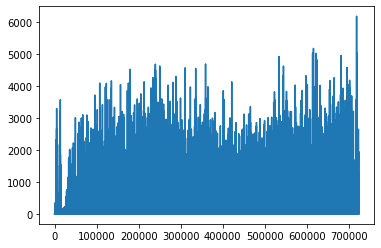

In [7]:
df_chome_work['customers_cnt'].plot()

In [8]:
df_home_work = pd.read_csv('./datasets/04_Matrix_Home_Work_July.csv')
df_home_work.describe()

,home_zid,work_zid,customers_cnt
count,20608.000000,20608.000000,20608.000000
mean,85.175320,83.041828,498.779988
std,68.865673,66.775621,3723.609495
min,-2.000000,-2.000000,0.000000
25%,35.000000,35.000000,9.000000
50%,72.000000,70.000000,31.000000
75%,108.000000,106.000000,106.000000
max,276.000000,276.000000,113207.000000


<AxesSubplot:>

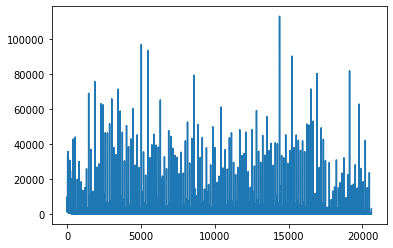

In [9]:
df_home_work['customers_cnt'].plot()

In [10]:
print('Количество значений с zid = -2:', df_home_work.loc[df_home_work['home_zid'] == -2].shape[0])

Количество значений с zid = -2: 146


In [11]:
print('Количество значений с zid = -2:', df_home_work.query('home_zid <= 0 or work_zid <= 0').shape[0])

Количество значений с zid = -2: 584


In [12]:
print(
    'Процент значений в Matrix_Home_Work_July с zid<=0:',
    round(df_home_work.loc[(df_home_work['home_zid'] <= 0) | (df_home_work['work_zid'] <= 0)].shape[0]/df_home_work.shape[0]*100, 2),
    '%'
)


Процент значений в Matrix_Home_Work_July с zid<=0: 2.83 %


In [13]:
print(
    'Процент значений в CMatrix_Home_Work_July с zid<=0:',
    round(df_chome_work.loc[(df_chome_work['home_zid'] <= 0) | (df_chome_work['work_zid'] <= 0)].shape[0]/df_chome_work.shape[0]*100, 2),
    '%'
)


Процент значений в CMatrix_Home_Work_July с zid<=0: 4.48 %


### Административное деление районов

Загрузим так же справочник соотношения секторов 500х500м и административного деления районов Москвы

In [14]:
df_sector_rel = pd.read_excel('./datasets/Справочник_соотношения_секторов_500х500м_и_адм_районов_МСК.xlsx')
df_sector_rel.head(3)

,cell_zid,area_peresechenia_s_admzone_kv.km,adm_zid,adm_name,okrug_name,sub_ter
0,32909,0.407116,216,Роговское,Троицкий административный округ,Новая Москва
1,32910,1.003458,216,Роговское,Троицкий административный округ,Новая Москва
2,33261,0.233312,216,Роговское,Троицкий административный округ,Новая Москва


In [15]:
df_sector_rel.describe()

,cell_zid,area_peresechenia_s_admzone_kv.km,adm_zid
count,13232.000000,1.323200e+04,13232.000000
mean,86399.263755,1.907860e+00,145.154776
std,26044.221345,8.655121e-01,88.766849
min,32909.000000,1.000000e-08,1.000000
25%,64572.750000,1.382770e+00,60.000000
50%,89067.000000,2.500603e+00,187.000000
75%,108079.250000,2.500670e+00,228.000000
max,139343.000000,2.500685e+00,276.000000


### Загрузим геоданные

In [16]:
shp_admzones = gpd.read_file('./datasets/admzones2021/admzones2021.shp')
shp_fishnet = gpd.read_file('./datasets/fishnet2021/fishnet2021.shp')

In [26]:
shp_admzones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   adm_zid     206 non-null    int64   
 1   adm_name    206 non-null    object  
 2   okrug_name  146 non-null    object  
 3   sub_ter     206 non-null    object  
 4   okrug_id    146 non-null    float64 
 5   area        206 non-null    float64 
 6   geometry    206 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 11.4+ KB


In [17]:
shp_admzones.head()

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry
0,519,Коломна,None,Московская область,NaN,1.728866e+09,"POLYGON ((38.30978 54.86069, 38.30978 54.86069..."
1,507,Дзержинский,None,Московская область,NaN,1.566430e+07,"POLYGON ((37.79389 55.62307, 37.79601 55.62424..."
2,109,Перово,Восточный административный округ,Старая Москва,561.0,9.829908e+06,"POLYGON ((37.75633 55.75959, 37.76380 55.76104..."
3,533,Мытищи,None,Московская область,NaN,4.312459e+08,"POLYGON ((37.73215 55.87984, 37.73064 55.88059..."
4,66,Тверской,Центральный административный округ,Старая Москва,569.0,7.322588e+06,"POLYGON ((37.61262 55.78248, 37.61457 55.78181..."


In [18]:
shp_fishnet.head()

,cell_zid,geometry
0,0,"POLYGON ((38.64721 54.25524, 38.64733 54.25973..."
1,1,"POLYGON ((38.65488 54.25517, 38.65500 54.25966..."
2,2,"POLYGON ((38.66255 54.25510, 38.66268 54.25959..."
3,3,"POLYGON ((38.67022 54.25502, 38.67035 54.25951..."
4,4,"POLYGON ((38.67789 54.25495, 38.67802 54.25944..."


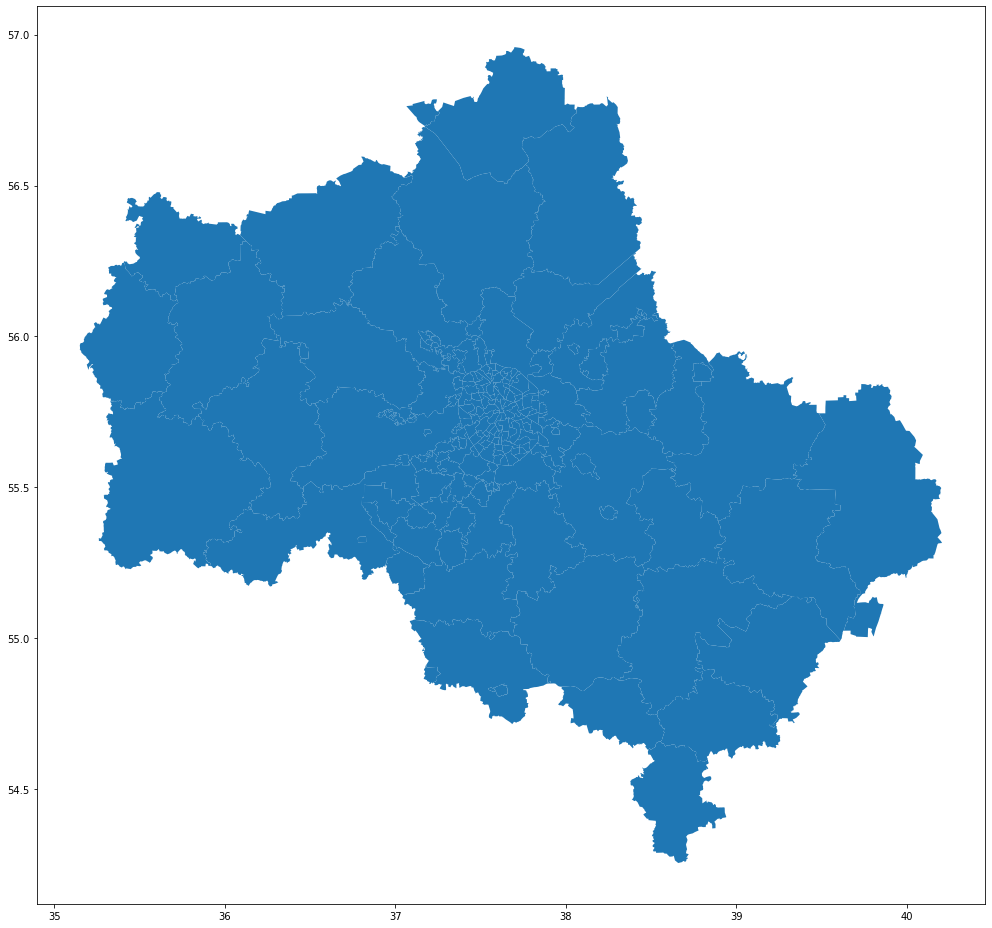

In [27]:
#shp_fishnet.plot(figsize=(17,17))
shp_admzones.plot(figsize=(17,17))
plt.show()

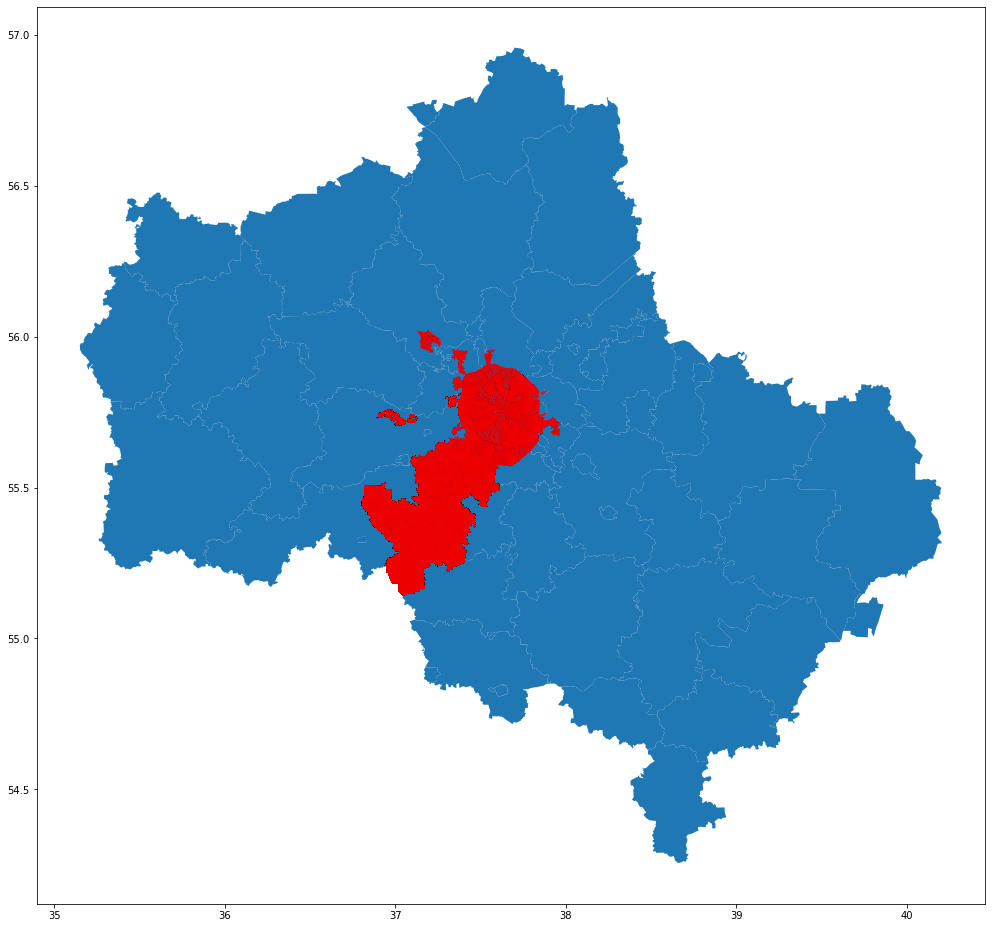

In [40]:
ax = shp_admzones.plot(figsize=(17,17))

pd.merge(
    shp_admzones,
    df_sector_rel[['cell_zid', 'adm_zid']],
    how="inner",
    on='adm_zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
).plot(figsize=(17,17), color='red', ax=ax, alpha=0.05)

plt.show()